In [2]:
from __future__ import division, absolute_import, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [3]:
import os
import sys
import importlib
module_path = os.path.abspath(os.path.join('../soft/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import republic_versions as rv

## Simple systematics, stellar variability and box-shaped transits

### Time array

In [4]:
Kp = 1000 # time range
step = 1  # time step
K = int(Kp/step) # no observations
t = np.arange(K)[::step] # time array

### Simulate stellar light curve 

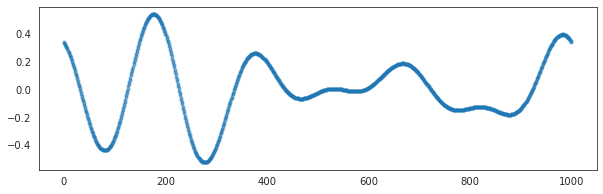

In [5]:
M = 6
importlib.reload(rv)
A_basis = rv.mk_basis(t, M, basis = 'sin', include_bias = False, doplot=False, normalise = True)
a = np.random.uniform(size=M) / M
A_true = np.dot(a,A_basis)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0.-',lw=0.5,alpha=0.5)

### Add transits

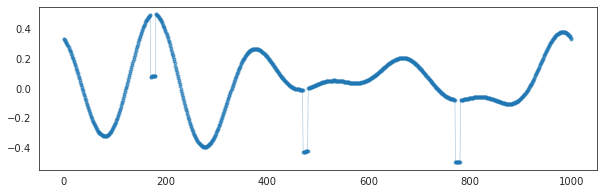

In [6]:
ptr = 300
t0tr = 175
dutr = 10
detr = 0.5
phtr = ((t-t0tr)%ptr)/ptr
phtr[phtr>0.5] -= 1
l = abs(phtr) <= (dutr/ptr/2)
A_true[l] -= detr
amin, amax = A_true.min(), A_true.max()
A_true = (A_true - amin) / (amax - amin) - 0.5

plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0.-',lw=0.5,alpha=0.5)

### Simulate systematics trends

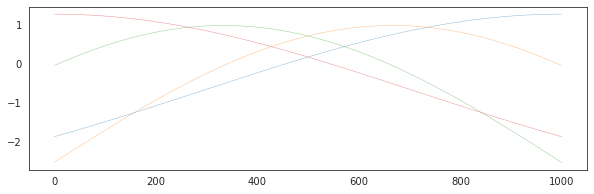

In [7]:
N = 4    # number of trends per camera
importlib.reload(rv)
T_basis = rv.mk_basis(t, N, basis = 'gauss', include_bias = False, doplot=False, normalise = True)
plt.figure(figsize=(10,3))
plt.plot(t,T_basis.T,'-',lw=0.5,alpha=0.5);

### Contruct 24 realisations of the light curve 
with different systematrics, white noise, and biases

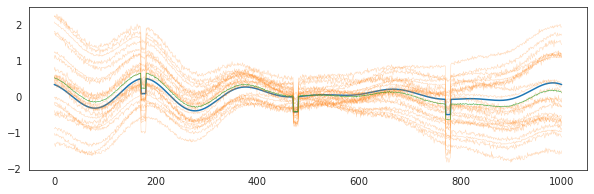

In [8]:
J = 24   # number of cameras
w_true = np.random.uniform(low=-0.5,high=0.5,size=(J,N))
sig = np.random.uniform(0.01,0.05,J)
F = np.zeros((J,K))
sigma = np.zeros_like(F)
plt.figure(figsize=(10,3))
plt.plot(t,A_true,'C0-')
for j in range(J):
    F[j,:] = A_true + np.dot(w_true[j,:], T_basis) + np.random.normal(scale=sig[j],size=K)
    sigma[j,:] = sig[j]
    plt.plot(t,F[j,:],'C1-',lw=0.5,alpha=.3)
Fm = np.mean(F,axis=0)
plt.plot(t,Fm,'C2-',lw=0.5)


In [9]:
Np = N #- 2
T_use = np.zeros((J,K,Np))
for j in range(J):
    T_use[j,:,:] = T_basis[:Np,:].T + np.random.normal(scale=0.01, size=(K,Np))

# Try corrections

In [13]:
importlib.reload(rv)
_, Fc_pdcls, Fc_av = rv.pdc_ls(F, T_use, sigma)

In [14]:
res = rv.republic(t, F, sigma, T = T_use, \
                  star_basis_type = 'eye')
Fc_rep1_each, Fc_rep1, Star_rep1, Sys_rep1, p_rep1 = res

In [18]:
res = rv.republic(t, F, sigma, T = None, \
                  star_basis_type = 'sin', L_in = M, \
                  sys_basis_type = 'gauss', N_in = N, \
                  lambda_reg = 1)
Fc_rep2_each, Fc_rep2, Star_rep2, Sys_rep2, p_rep2 = res

In [19]:
res = rv.republic(t, F, sigma, T = T_use, \
                  star_basis_type = 'sin', L_in = M, \
                  lambda_reg=1)
Fc_rep3_each, Fc_rep3, Star_rep3, Sys_rep3, p_rep3 = res

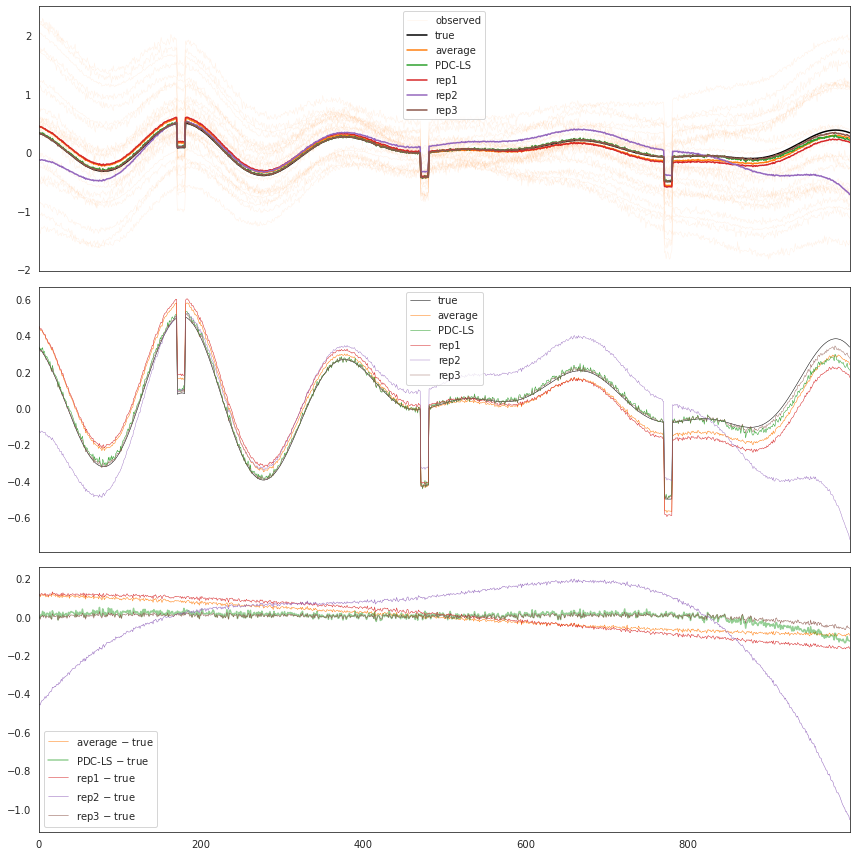

In [20]:
fig,axes=plt.subplots(3,1,figsize=(12,12),sharex=True, sharey=False)
for j in range(J):
    if j == 0:
        axes[0].plot(t,F[j,:],'C1-',lw=0.5,alpha=.1, label = 'observed')
    else:
        axes[0].plot(t,F[j,:],'C1-',lw=0.5,alpha=.1)
axes[0].plot(t,A_true,'k-',label='true')
axes[0].plot(t,Fc_av,'C1-',label='average')
axes[0].plot(t,Fc_pdcls,'C2-',label='PDC-LS')
axes[0].plot(t,Fc_rep1,'C3-',label='rep1')
axes[0].plot(t,Fc_rep2,'C4-',label='rep2')
axes[0].plot(t,Fc_rep3,'C5-',label='rep3')
axes[0].legend(loc=0)
axes[1].plot(t,A_true,'k-',lw=0.5,label='true')
axes[1].plot(t,Fc_av,'C1-',lw=0.5,label='average')
axes[1].plot(t,Fc_pdcls,'C2-',lw=0.5,label='PDC-LS')
axes[1].plot(t,Fc_rep1,'C3-',lw=0.5,label='rep1')
axes[1].plot(t,Fc_rep2,'C4-',lw=0.4,label='rep2')
axes[1].plot(t,Fc_rep3,'C5-',lw=0.4,label='rep3')
axes[1].legend(loc=0)
axes[2].plot(t,Fc_av - A_true,'C1-',lw = 0.5,label='average $-$ true')
axes[2].plot(t,Fc_pdcls - A_true,'C2-',alpha = 0.5,label='PDC-LS $-$ true')
axes[2].plot(t,Fc_rep1 - A_true,'C3-',lw=0.5,label='rep1 $-$ true')
axes[2].plot(t,Fc_rep2 - A_true,'C4-',lw=0.5,label='rep2 $-$ true')
axes[2].plot(t,Fc_rep3 - A_true,'C5-',lw=0.5,label='rep3 $-$ true')
axes[2].legend(loc=0)
plt.xlim(t.min(),t.max())
#plt.xlim(400,600)
plt.tight_layout();

### Obviously, republic 2 doesn't work in this case because the systematics can't be approximated by polynomials. But it's also not quite right - shouldn't be this wrong.